# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [1]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import matplotlib.patches as patches

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.root = root_dir
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))

        self.id_to_category = {c['id']: c['name'] for c in self.anns['categories']}
        self.category_to_id = {c['name']: c['id'] for c in self.anns['categories']}
        self.categories = [c['name'] for c in self.anns['categories']]

        # --- Step 1: Pre-process ALL annotations and identify problematic images ---
        self.all_image_ids_from_json = []
        self.all_file_names_from_json = []
        for img_info in self.anns['images']:
            self.all_file_names_from_json.append(img_info['path'])
            self.all_image_ids_from_json.append(img_info['id'])
        self.all_image_ids_from_json = np.asarray(self.all_image_ids_from_json) # Convert to numpy for easy indexing/masking

        problematic_image_ids = set() # Store image_ids that have any malformed piece annotation
        # This will store ONLY VALID annotations, grouped by image_id
        self.image_annotations = {}

        for ann_idx, ann in enumerate(self.anns['annotations']['pieces']):
            # Ensure required attributes for object detection are present
            if 'bbox' not in ann or 'category_id' not in ann:
                #print(f"Warning: Annotation at index {ann_idx} for image_id {ann.get('image_id', 'N/A')} is malformed (missing 'bbox' or 'category_id'). This image will be excluded.")
                if 'image_id' in ann:
                    problematic_image_ids.add(ann['image_id'])
                continue # Skip this malformed annotation

            image_id = ann['image_id']
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)


        # --- Step 2: Filter images based on split and problematic annotations ---
        if partition == 'train':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else: # 'test'
            raw_split_image_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        self.file_names = [] # Final list of file names for this split
        self.image_ids = []  # Final list of original image IDs for this split

        # Iterate through all images (which you already have indexed by self.all_image_ids_from_json)
        for i, img_id in enumerate(self.all_image_ids_from_json):
            # Check if image belongs to current split AND is not marked as problematic
            if img_id in raw_split_image_ids and img_id not in problematic_image_ids:
                # Also, ensure that the image actually has valid annotations after filtering.
                # An image could be in the split, not problematic, but simply have no pieces.
                # Or all its pieces were problematic, so it has no valid annotations left.
                if img_id in self.image_annotations and len(self.image_annotations[img_id]) > 0:
                    self.image_ids.append(img_id)
                    self.file_names.append(self.all_file_names_from_json[i])
                else:
                    # Optional: Print why an image might be excluded if it's in the split but has no valid annotations
                    print(f"Info: Image ID {img_id} (file: {self.all_file_names_from_json[i]}) in '{partition}' split has no valid annotations after initial filtering. Excluding.")

        self.file_names = np.asarray(self.file_names)
        self.image_ids = np.asarray(self.image_ids)

        self.transform = transform

        print(f"Number of {partition} images: {len(self.file_names)}")


    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root, self.file_names[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_image_id = self.image_ids[idx] # Get the true original ID for this image in the split
        # Retrieve annotations using the pre-processed dictionary
        annotations_for_image = self.image_annotations.get(original_image_id, [])

        boxes = []
        labels = []

        # Iterate through the (already filtered and valid) annotations for this image
        for ann in annotations_for_image:
            x_min, y_min, width, height = ann['bbox']
            x_max = x_min + width
            y_max = y_min + height
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann['category_id'])

        # Convert to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if len(labels) > 0 else torch.zeros((0,), dtype=torch.int64)

        # Create the target dictionary required by Faster R-CNN
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([original_image_id])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

train_dataset = ChessDataset('./chessred2k', 'train', data_aug)
valid_dataset = ChessDataset('./chessred2k', 'valid', data_in)
test_dataset = ChessDataset('./chessred2k', 'test', data_in)

In [12]:
# Device configuration (improved version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Hyperparameters (consider these adjustments)
batch_size = 8  # Reduced from 16 for better memory management with Faster R-CNN
num_workers = 0  # Optimal for most systems

def collate_fn(batch):
    """
    Enhanced collate function for object detection.
    Handles:
    - Empty targets
    - Image tensor conversion
    - Device movement
    """
    images, targets = zip(*batch)
    
    processed_images = []
    processed_targets = []
    
    for image, target in zip(images, targets):
        # Convert image if not already a tensor
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        
        # Handle empty targets
        if len(target['boxes']) == 0:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0,), dtype=torch.int64)
        else:
            # Verify bbox format (x1,y1,x2,y2)
            assert target['boxes'].shape[1] == 4, "Bounding boxes must have shape [N, 4]"
            
        processed_images.append(image)
        processed_targets.append(target)
    
    return processed_images, processed_targets

# DataLoaders with improved settings
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Prevents partial batches
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True  # Keep all validation samples
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,  # Often better to use batch_size=1 for testing
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True if device.type == 'cuda' else False,
    drop_last=True
)

Using cuda device


In [ ]:
for i, (images, targets) in enumerate(valid_dataloader):
    print(f"\nBatch {i}:")
    for j, t in enumerate(targets):
        print(f"  Target {j}:")
        print(f"    Boxes shape: {t['boxes'].shape}")
        print(f"    Labels shape: {t['labels'].shape}")
        if t['boxes'].shape[0] != t['labels'].shape[0]:
            print("    Inconsistency!")
    
    if i >= 4:
        break

In [6]:
#checking if the dataset is loaded correctly
for i in range(len(valid_dataset)):
    _, target = valid_dataset[i]
    assert target['boxes'].dim() == 2 and target['boxes'].shape[1] == 4

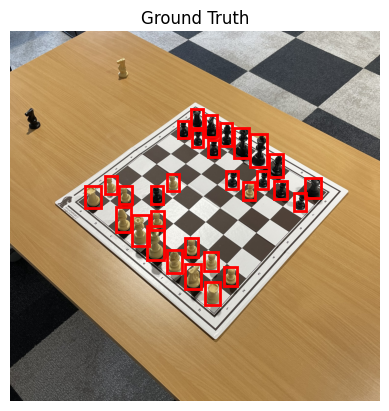

In [4]:
# validating dataset with pieces

def plot_boxes(image, boxes, title="Detections"):
    plt.imshow(image)
    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        plt.gca().add_patch(rect)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Ejemplo de uso con tus datos:
image, target = train_dataset[10]
denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
             torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
denorm_img = np.clip(denorm_img, 0, 1)

plot_boxes(denorm_img, target['boxes'], "Ground Truth")

## Defining the model

We will use a pre-trained ResNet50 network.

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    

num_classes = 12  # 12 pieces + empty space
    

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)


Using cuda device


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3 
gamma = 0.1

# Optimizador y scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, 
                     momentum=momentum, 
                     weight_decay=weight_decay)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    total_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch}')
    
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        loss_classifier += loss_dict.get('loss_classifier', 0).item()
        loss_box_reg += loss_dict.get('loss_box_reg', 0).item()
        loss_objectness += loss_dict.get('loss_objectness', 0).item()
        loss_rpn_box_reg += loss_dict.get('loss_rpn_box_reg', 0).item()
        
        progress_bar.set_postfix({
            'Loss': total_loss/(progress_bar.n+1),
            'Cls': loss_classifier/(progress_bar.n+1),
            'Box': loss_box_reg/(progress_bar.n+1)
        })
    
    return total_loss / len(data_loader)

In [9]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()
    total_loss = 0.0
    processed_batches = 0
    
    # Configuración especial para evitar errores de dimensiones
    original_score_thresh = model.roi_heads.score_thresh
    model.roi_heads.score_thresh = 0.0  # Desactiva filtrado inicial
    
    for batch_idx, (images, targets) in enumerate(tqdm(data_loader, desc='Validating')):
        # 1. Conversión explícita y verificación
        images = [img.to(device) for img in images]
        targets = [{
            'boxes': t['boxes'].float().to(device),
            'labels': t['labels'].long().to(device)
        } for t in targets]
        
        # 2. Validación dimensional estricta
        for t in targets:
            assert t['boxes'].shape[1] == 4, f"Boxes deben tener 4 coordenadas, obtuviste {t['boxes'].shape[1]}"
            assert len(t['boxes']) == len(t['labels']), "Boxes y labels deben tener la misma longitud"
        
        # 3. Forward pass con manejo de excepciones interno
        loss_dict = model(images, targets)
        
        # 4. Cálculo de pérdida unificado
        if isinstance(loss_dict, dict):
            losses = sum(loss for loss in loss_dict.values())
        else:  # Caso raro de lista de diccionarios
            losses = sum(sum(l.values()) for l in loss_dict)
        
        total_loss += losses
        processed_batches += 1
                
    
    # Restaura configuración original
    model.roi_heads.score_thresh = original_score_thresh
    
    if processed_batches == 0:
        print("\n¡ADVERTENCIA CRÍTICA: Ningún batch procesado exitosamente!")
        print("Posibles causas:")
        print("1. Targets mal formados (verificar shapes)")
        print("2. Valores NaN/infinitos en los datos")
        print("3. Conflicto entre versiones de librerías")
        return float('inf')
    
    return total_loss / processed_batches

In [10]:
num_epochs = 10

def train_model(model, optimizer, train_dataloader, valid_dataloader, device, num_epochs, early_stop_patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(num_epochs):
        # Entrenamiento
        train_loss = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
        
        # Validación
        val_loss = evaluate(model, valid_dataloader, device)
        lr_scheduler.step()
        
        # Guardar mejor modelo
        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
            print(f"¡Nuevo mejor modelo guardado! (val_loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"Early stopping en epoch {epoch+1}")
                break
        
        # Log de progreso
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 60)

    print("¡Entrenamiento completado!")

In [11]:
train_model(model, optimizer, train_dataloader, valid_dataloader, device, num_epochs)

Epoch 0:   7%|▋         | 12/180 [00:27<05:54,  2.11s/it, Loss=2.59, Cls=0.886, Box=0.705]

In [16]:
def plot_predictions(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        image, target = dataset[idx]
        img_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(img_tensor)
        
        # Procesamiento de la imagen para visualización
        denorm_img = (image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)) + \
                     torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        denorm_img = denorm_img.permute(1, 2, 0).cpu().numpy()
        denorm_img = np.clip(denorm_img, 0, 1)
        
        # Visualizar
        fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
        # Ground Truth
        ax[0].imshow(denorm_img)
        for box in target['boxes']:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=1, edgecolor='g', facecolor='none'
            )
            ax[0].add_patch(rect)
        ax[0].set_title('Ground Truth')
        ax[0].axis('off')
        
        # Predicciones
        ax[1].imshow(denorm_img)
        for box in prediction[0]['boxes'].cpu():
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=1, edgecolor='r', facecolor='none'
            )
            ax[1].add_patch(rect)
        ax[1].set_title('Predictions')
        ax[1].axis('off')
        
        plt.show()

In [ ]:
# Verificar disponibilidad de GPU
print(f"Using device: {device}")

# Cargar mejor modelo
model.load_state_dict(torch.load('best_model.pth', map_location=device))

# Visualizar resultados
plot_predictions(model, test_dataset)

## Train the model

In [9]:
import torch.optim as optim

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer_phase1 = optim.Adam(model1.fc.parameters(), lr=0.001)
optimizer_phase2 = optim.Adam(model1.fc.parameters(), lr=0.0001)

## Analyse training evolution

In [ ]:
# 1 Phase: train with frozen layers
for name, param in model1.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

train_history_phase1, val_history_phase1 = train_classifier(
    model1, train_dataloader, valid_dataloader, loss_fn, optimizer_phase1, device, num_epochs=10
)

Plot loss and accuracy throughout training on train and validation data

In [14]:
# Combine training histories from both phases
train_history = {
    'loss': train_history_phase1['loss'] + train_history_phase2['loss'],
    'acc': train_history_phase1['acc'] + train_history_phase2['acc']
}

val_history = {
    'loss': val_history_phase1['loss'] + val_history_phase2['loss'],
    'acc': val_history_phase1['acc'] + val_history_phase2['acc']
}

In [17]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['acc'], label='train')
    plt.plot(val_history['acc'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

In [ ]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Evaluate model on test data
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def test_classifier(model, test_dataloader, device):
    model.eval()
    model.to(device)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            _, labels_idx = labels.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels_idx.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'true_labels': all_labels
    }
test_results = test_classifier(model1, test_dataloader, device)

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?